# Convert a TensorFlow Model to OpenVINO™

This short tutorial shows how to convert a TensorFlow [MobileNetV3](https://docs.openvino.ai/2023.0/omz_models_model_mobilenet_v3_small_1_0_224_tf.html) image classification model to OpenVINO [Intermediate Representation](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_IR_and_opsets.html) (OpenVINO IR) format, using [Model Conversion API](https://docs.openvino.ai/2023.0/openvino_docs_model_processing_introduction.html). After creating the OpenVINO IR, load the model in [OpenVINO Runtime](https://docs.openvino.ai/nightly/openvino_docs_OV_UG_OV_Runtime_User_Guide.html) and do inference with a sample image.  

#### Table of content:
- [Imports](#Imports-Uparrow)
- [Settings](#Settings-Uparrow)
- [Download model](#Download-model-Uparrow)
- [Convert a Model to OpenVINO IR Format](#Convert-a-Model-to-OpenVINO-IR-Format-Uparrow)
    - [Convert a TensorFlow Model to OpenVINO IR Format](#Convert-a-TensorFlow-Model-to-OpenVINO-IR-Format-Uparrow)
- [Test Inference on the Converted Model](#Test-Inference-on-the-Converted-Model-Uparrow)
    - [Load the Model](#Load-the-Model-Uparrow)
- [Select inference device](#Select-inference-device-Uparrow)
    - [Get Model Information](#Get-Model-Information-Uparrow)
    - [Load an Image](#Load-an-Image-Uparrow)
    - [Do Inference](#Do-Inference-Uparrow)
- [Timing](#Timing-Uparrow)


In [1]:
# Install openvino package
%pip install -q "openvino>=2023.1.0"

## Imports [$\Uparrow$](#Table-of-content:)


In [2]:
import time
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
import tensorflow as tf

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

from notebook_utils import download_file

2023-07-10 10:50:15.998011: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 10:50:16.035590: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 10:50:16.655183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Settings [$\Uparrow$](#Table-of-content:)


In [3]:
# The paths of the source and converted models.
model_dir = Path("model")
model_dir.mkdir(exist_ok=True)

model_path = Path("model/v3-small_224_1.0_float")

ir_path = Path("model/v3-small_224_1.0_float.xml")

## Download model [$\Uparrow$](#Table-of-content:)

Load model using [tf.keras.applications api](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Small) and save it to the disk.

In [4]:
model = tf.keras.applications.MobileNetV3Small()
model.save(model_path)

2023-07-10 10:50:17.847384: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2023-07-10 10:50:23.549399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,1,1024]
	 [[{{node inputs}}]]
2023-07-10 10:50:27.144105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,1,1024]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model/v3-small_224_1.0_float/assets


INFO:tensorflow:Assets written to: model/v3-small_224_1.0_float/assets


## Convert a Model to OpenVINO IR Format [$\Uparrow$](#Table-of-content:)

### Convert a TensorFlow Model to OpenVINO IR Format [$\Uparrow$](#Table-of-content:)

Use the model conversion Python API to convert the TensorFlow model to OpenVINO IR. The `ov.convert_model` function accept path to saved model directory and returns OpenVINO Model class instance which represents this model. Obtained model is ready to use and to be loaded on a device using `ov.compile_model` or can be saved on a disk using the `ov.save_model` function.
See the [tutorial](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_prepare_model_convert_model_Convert_Model_From_TensorFlow.html) for more information about using model conversion API with TensorFlow models.

In [5]:
# Run model conversion API if the IR model file does not exist
if not ir_path.exists():
    print("Exporting TensorFlow model to IR... This may take a few minutes.")
    ov_model = ov.convert_model(model_path, input=[[1, 224, 224, 3]])
    ov.save_model(ov_model, ir_path)
else:
    print(f"IR model {ir_path} already exists.")

Exporting TensorFlow model to IR... This may take a few minutes.


## Test Inference on the Converted Model [$\Uparrow$](#Table-of-content:)


### Load the Model [$\Uparrow$](#Table-of-content:)


In [6]:
core = ov.Core()
model = core.read_model(ir_path)

## Select inference device [$\Uparrow$](#Table-of-content:)

select device from dropdown list for running inference using OpenVINO

In [7]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [8]:
compiled_model = core.compile_model(model=model, device_name=device.value)

### Get Model Information [$\Uparrow$](#Table-of-content:)


In [9]:
input_key = compiled_model.input(0)
output_key = compiled_model.output(0)
network_input_shape = input_key.shape 

### Load an Image [$\Uparrow$](#Table-of-content:)

Load an image, resize it, and convert it to the input shape of the network.

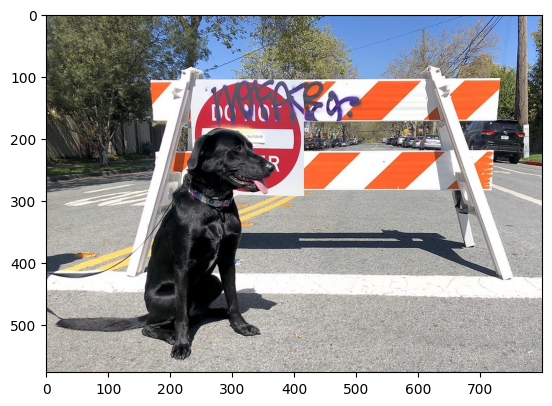

In [10]:
# Download the image from the openvino_notebooks storage
image_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
    directory="data"
)

# The MobileNet network expects images in RGB format.
image = cv2.cvtColor(cv2.imread(filename=str(image_filename)), code=cv2.COLOR_BGR2RGB)

# Resize the image to the network input shape.
resized_image = cv2.resize(src=image, dsize=(224, 224))

# Transpose the image to the network input shape.
input_image = np.expand_dims(resized_image, 0)

plt.imshow(image);

### Do Inference [$\Uparrow$](#Table-of-content:)


In [11]:
result = compiled_model(input_image)[output_key]

result_index = np.argmax(result)

In [12]:
# Download the datasets from the openvino_notebooks storage
image_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/datasets/imagenet/imagenet_2012.txt",
    directory="data"
)

# Convert the inference result to a class name.
imagenet_classes = image_filename.read_text().splitlines()

imagenet_classes[result_index]

'n02099267 flat-coated retriever'

## Timing [$\Uparrow$](#Table-of-content:)

Measure the time it takes to do inference on thousand images. This gives an indication of performance. For more accurate benchmarking, use the [Benchmark Tool](https://docs.openvino.ai/2023.0/openvino_inference_engine_tools_benchmark_tool_README.html) in OpenVINO. Note that many optimizations are possible to improve the performance. 

In [13]:
num_images = 1000

start = time.perf_counter()

for _ in range(num_images):
    compiled_model([input_image])

end = time.perf_counter()
time_ir = end - start

print(
    f"IR model in OpenVINO Runtime/CPU: {time_ir/num_images:.4f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)

IR model in OpenVINO Runtime/CPU: 0.0011 seconds per image, FPS: 924.82
